# StakeIQ - Research Assistant in Sports


In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python

Setup

In [2]:
import os
from google.colab import userdata

def _set_env(var: str):
    if not os.environ.get(var):
        # Get API key from userdata
        api_key = userdata.get(var)
        # Check if API key is valid
        if not api_key:
            raise ValueError(f"API key for {var} not found in userdata. Please set it using `userdata.set('{var}', 'YOUR_API_KEY')`.")
        # Set environment variable
        os.environ[var] = api_key

_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")
_set_env("LANGCHAIN_API_KEY")

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "stake-iq"

from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.1)


Create analysts and review them using human-in-the-loop.

In [3]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

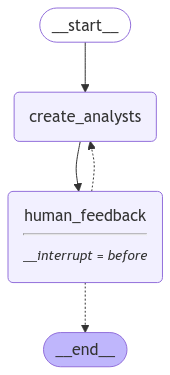

In [4]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}

2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts:

{human_analyst_feedback}

3. Determine the most interesting themes based upon documents and / or feedback above.

4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystsState):

    """ Create analysts """

    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')

    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback,
                                                            max_analysts=max_analysts)

    # Generate question
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])

    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"

    # Otherwise end
    return END

# Add nodes and edges
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [5]:
# Input
max_analysts = 3
topic = "NFL game outcome between San Francisco 49ers and Green Bay Packers"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: John Smith
Affiliation: ESPN
Role: Sports Analyst
Description: John focuses on statistical analysis and game predictions, using advanced metrics to evaluate team performance and player statistics.
--------------------------------------------------
Name: Lisa Johnson
Affiliation: NFL Network
Role: Game Strategist
Description: Lisa specializes in game strategy and coaching decisions, analyzing play-calling and team tactics to understand how they impact game outcomes.
--------------------------------------------------
Name: Mike Thompson
Affiliation: Bleacher Report
Role: Fan Engagement Specialist
Description: Mike engages with fan perspectives and narratives, exploring how public sentiment and team rivalries influence the perception of game outcomes.
--------------------------------------------------


In [6]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [7]:
# Update the state to add the human_feedback
graph.update_state(thread, {"human_analyst_feedback":
                            "Add in someone with a sports betting perspective"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa6537-6268-643d-8002-4e6ad62adbbe'}}

In [8]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: John Smith
Affiliation: ESPN
Role: Sports Analyst
Description: John focuses on statistical analysis and game predictions, using advanced metrics to evaluate team performance and player statistics.
--------------------------------------------------
Name: Lisa Johnson
Affiliation: NFL Network
Role: Game Strategist
Description: Lisa specializes in game strategy and coaching decisions, analyzing play-calling and team tactics to understand how they impact game outcomes.
--------------------------------------------------
Name: Mike Thompson
Affiliation: Bleacher Report
Role: Fan Engagement Specialist
Description: Mike engages with fan perspectives and narratives, exploring how public sentiment and team rivalries influence the perception of game outcomes.
--------------------------------------------------
Name: Mark Thompson
Affiliation: ESPN
Role: Sports Analyst
Description: Mark specializes in analyzing NFL games, focusing on team performance metrics, player statistics, and historical

In [9]:
# If looks good, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback":
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa6537-8293-6d46-8004-460a3592edef'}}

In [10]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [11]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [12]:
final_state.next

()

In [13]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50)

Name: Mark Thompson
Affiliation: ESPN
Role: Sports Analyst
Description: Mark specializes in analyzing NFL games, focusing on team performance metrics, player statistics, and historical matchups. He provides insights into the strategic elements that could influence the outcome of the game.
--------------------------------------------------
Name: Sarah Johnson
Affiliation: Bleacher Report
Role: Betting Analyst
Description: Sarah offers a sports betting perspective, analyzing odds, betting trends, and public sentiment. She focuses on how these factors can impact the betting landscape for the 49ers vs. Packers game.
--------------------------------------------------
Name: James Carter
Affiliation: NFL Network
Role: Tactical Analyst
Description: James examines the tactical aspects of the game, including offensive and defensive schemes, player matchups, and coaching strategies. He provides in-depth analysis on how these elements could determine the winner.
-----------------------------------

## Conduct Interview

### Generate Question

The analyst will ask questions to the expert.

In [14]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [15]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic.

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.

2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}

Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.

When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)

    # Write messages to state
    return {"messages": [question]}

In [16]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

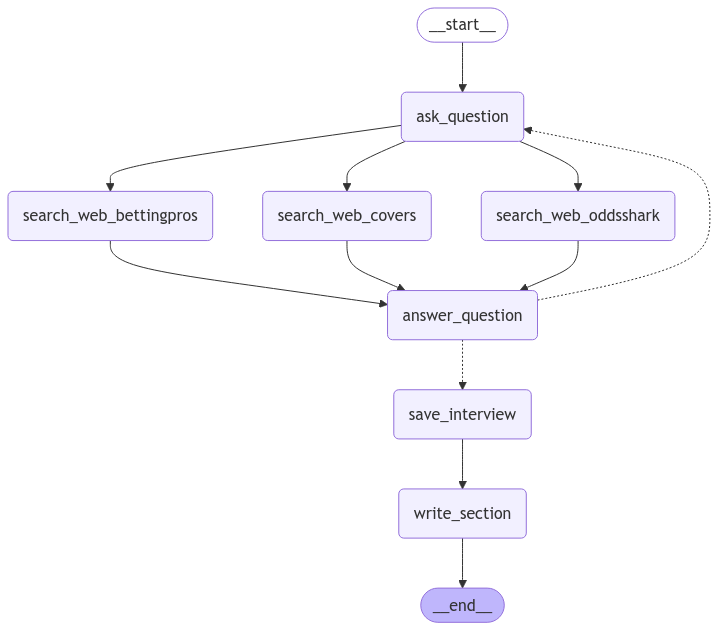

In [17]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert.

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.

First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web_oddsshark(state: InterviewState):

    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])

    # Search
    search_docs = tavily_search.invoke(search_query.search_query, include_domains=["oddsshark.com"])

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def search_web_covers(state: InterviewState):

    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])

    # Search
    search_docs = tavily_search.invoke(search_query.search_query, include_domains=["covers.com"])

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def search_web_bettingpros(state: InterviewState):

    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])

    # Search
    search_docs = tavily_search.invoke(search_query.search_query, include_domains=["bettingpros.com"])

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}.

You goal is to answer a question posed by the interviewer.

To answer question, use this context:

{context}

When answering questions, follow these guidelines:

1. Use only the information provided in the context.

2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1].

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc

6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list:

[1] assistant/docs/llama3_1.pdf, page 7

And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):

    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)

    # Name the message as coming from the expert
    answer.name = "expert"

    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):

    """ Save interviews """

    # Get messages
    messages = state["messages"]

    # Convert interview to a string
    interview = get_buffer_string(messages)

    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState,
                   name: str = "expert"):

    """ Route between question and answer """

    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]

    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer.

Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents:
- The name of each source document is at the start of the document, with the <Document tag.

2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers

3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst:
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents

6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/

8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]

    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")])

    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web_oddsshark", search_web_oddsshark)
interview_builder.add_node("search_web_covers", search_web_covers)
interview_builder.add_node("search_web_bettingpros", search_web_bettingpros)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web_oddsshark")
interview_builder.add_edge("ask_question", "search_web_covers")
interview_builder.add_edge("ask_question", "search_web_bettingpros")
interview_builder.add_edge("search_web_oddsshark", "answer_question")
interview_builder.add_edge("search_web_covers", "answer_question")
interview_builder.add_edge("search_web_bettingpros", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [18]:
# Pick one analyst
analysts[2]

Analyst(affiliation='NFL Network', name='James Carter', role='Tactical Analyst', description='James examines the tactical aspects of the game, including offensive and defensive schemes, player matchups, and coaching strategies. He provides in-depth analysis on how these elements could determine the winner.')

Here, we run the interview passing an index of the llama3.1 paper, which is related to our topic.

In [19]:
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[2], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## Tactical Breakdown of the 49ers' Game-Winning Drive Against the Packers

### Summary
In a thrilling Divisional Round matchup of the 2023 NFL Playoffs, the San Francisco 49ers executed a game-winning drive against the Green Bay Packers, culminating in a 24-21 victory. This game showcased the tactical prowess of the 49ers, particularly under the guidance of head coach Kyle Shanahan. The 49ers' ability to adapt their offensive schemes and leverage player matchups was pivotal in overcoming a challenging second half where they initially trailed.

The game-winning drive was marked by a strategic blend of running and passing plays, with Christian McCaffrey playing a crucial role. His versatility allowed the 49ers to maintain offensive momentum, culminating in a decisive 6-yard touchdown run that sealed the game with just over a minute remaining. Notably, the 49ers' defense also stepped up, with Dre Greenlaw intercepting Jordan Love to secure the win, highlighting the importance of defensive schemes in high-pressure situations.

Interestingly, while the 49ers emerged victorious, the Packers outperformed them for significant stretches of the game, particularly in the first half. This dynamic illustrates the unpredictable nature of playoff football, where tactical adjustments and player performances can dramatically shift the game's outcome. The insights gathered from the analysis of this game reveal how critical it is for teams to remain resilient and adaptable, especially in the face of adversity.

1. [Analyzing 49ers Game-Winning Drive vs. Packers - Baldy Breakdowns](https://www.nfl.com/videos/analyzing-49ers-game-winning-drive-vs-packers-baldy-breakdowns)  
2. [What We Learned: Packers vs. 49ers Divisional Round](https://www.nfl.com/news/2023-nfl-playoffs-what-we-learned-packers-49ers-divisional-round)  
3. [Game Recap: 49ers 24, Packers 21](https://www.pff.com/news/nfl-divisional-round-game-recap-san-francisco-49ers-24-green-bay-packers-21)  
4. [Christian McCaffrey's Impact in the Game](https://www.espn.com/nfl/recap?gameId=401547756)  

### Sources
[1] https://www.nfl.com/videos/analyzing-49ers-game-winning-drive-vs-packers-baldy-breakdowns  
[2] https://www.nfl.com/news/2023-nfl-playoffs-what-we-learned-packers-49ers-divisional-round  
[3] https://www.pff.com/news/nfl-divisional-round-game-recap-san-francisco-49ers-24-green-bay-packers-21  
[4] https://www.espn.com/nfl/recap?gameId=401547756  

### Parallelze interviews: Map-Reduce

We parallelize the interviews via the `Send()` API, a map step.

We combine them into the report body in a reduce step.

### Finalize

We add a final step to write an intro and conclusion to the final report.

In [20]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

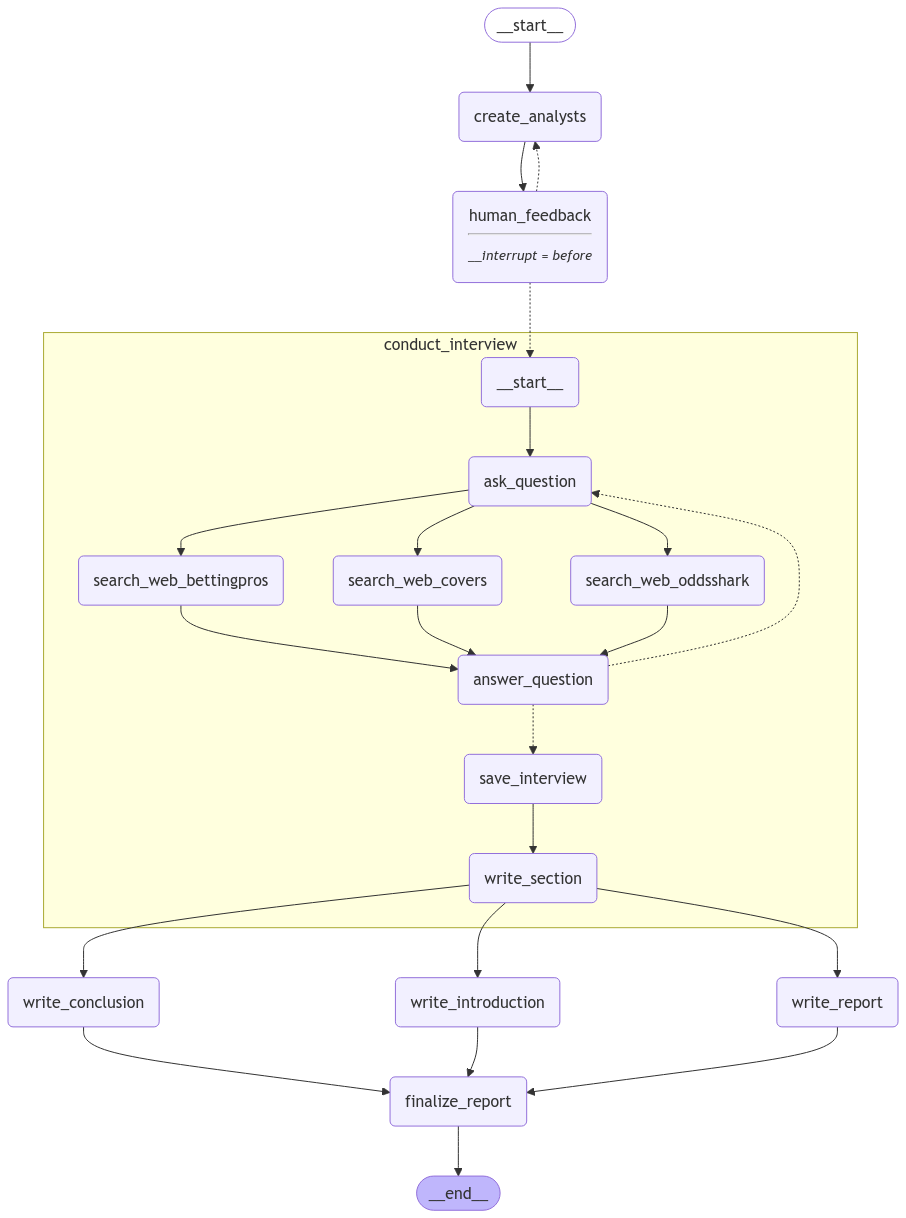

In [21]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

report_writer_instructions = """You are a technical writer creating a report on this overall topic:

{topic}

You have a team of analysts. Each analyst has done two things:

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task:

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos.
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:

1. Use markdown formatting.
2. Include no pre-amble for the report.
3. Use no sub-heading.
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from:

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")])
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting.

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header.

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report

    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")])
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report

    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")])
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Add nodes and edges
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

**Let**'s ask a question about NFL.

In [22]:
# Inputs
max_analysts = 3
topic = "NFL game outcome between San Francisco 49ers and Green Bay Packers"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts},
                          thread,
                          stream_mode="values"):

    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: John Smith
Affiliation: ESPN
Role: Sports Analyst
Description: John focuses on statistical analysis and game predictions, utilizing advanced metrics to evaluate team performance and player efficiency.
--------------------------------------------------
Name: Lisa Johnson
Affiliation: NFL Network
Role: Game Strategist
Description: Lisa specializes in game strategy and play-calling, analyzing how coaching decisions impact game outcomes and team dynamics.
--------------------------------------------------
Name: Mike Thompson
Affiliation: Bleacher Report
Role: Fan Engagement Specialist
Description: Mike engages with fan perspectives and sentiments, exploring how public opinion and fan culture influence team morale and game outcomes.
--------------------------------------------------


In [23]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback":
                                "Add in someone with a sports betting perspective"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa6539-22a8-6060-8002-56bdabfc53c4'}}

In [24]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: John Smith
Affiliation: ESPN
Role: Sports Analyst
Description: John focuses on statistical analysis and game predictions, utilizing advanced metrics to evaluate team performance and player efficiency.
--------------------------------------------------
Name: Lisa Johnson
Affiliation: NFL Network
Role: Game Strategist
Description: Lisa specializes in game strategy and play-calling, analyzing how coaching decisions impact game outcomes and team dynamics.
--------------------------------------------------
Name: Mike Thompson
Affiliation: Bleacher Report
Role: Fan Engagement Specialist
Description: Mike engages with fan perspectives and sentiments, exploring how public opinion and fan culture influence team morale and game outcomes.
--------------------------------------------------
Name: Mark Johnson
Affiliation: ESPN
Role: Sports Analyst
Description: Mark provides in-depth analysis of NFL games, focusing on team strategies, player performances, and historical matchups. He aims to gi

In [25]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback":
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa6539-434f-67b7-8004-29c2cd910d98'}}

In [26]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_conclusion
--Node--
write_introduction
--Node--
write_report
--Node--
finalize_report


In [27]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# Clash of Titans: 49ers vs. Packers

## Introduction

The rivalry between the San Francisco 49ers and the Green Bay Packers is a hallmark of NFL history, marked by fierce competition and unforgettable moments. This report delves into their recent encounters, particularly the thrilling 2023 NFC Divisional Round where the 49ers narrowly triumphed 24-21. Key player performances, including Christian McCaffrey's pivotal touchdown and Aaron Jones' impressive rushing yards, highlight the stakes involved. Additionally, we explore the betting landscape and historical context, revealing how injuries and weather conditions could influence future matchups. As both teams evolve, the anticipation for their next showdown continues to grow.

---


The rivalry between the Green Bay Packers and the San Francisco 49ers is one of the most significant in NFL history, marked by intense matchups and memorable performances. Recent encounters, particularly the 2023 NFC Divisional Round where the 49ers narrowly defeated the Packers 24-21, have underscored the evolving strategies of both teams. The Packers demonstrated resilience, overcoming a challenging 2-5 start to reach the playoffs, while the 49ers showcased their strategic prowess with a game-winning drive led by quarterback Brock Purdy.

Key player performances were pivotal in the recent matchup, with Christian McCaffrey scoring a decisive touchdown and Packers' running back Aaron Jones contributing significantly with 108 yards on 18 carries. Injuries also played a role, as the Packers lost right tackle Zach Tom and the 49ers were without wide receiver Deebo Samuel for a significant portion of the game. This context adds depth to the rivalry, as both teams adapt to player availability and game-day conditions.

The historical context of the rivalry is compelling, with the Packers leading the all-time series 38-34, including a 6-4 record in postseason play. This competitive edge heightens anticipation for each matchup, as fans and analysts seek trends that could influence future games. The recent performances suggest a shift in dynamics, with the 49ers demonstrating a strong offensive strategy that leverages their playmakers, while the Packers continue to rely on their established running game and the development of quarterback Jordan Love.

Looking ahead to the Week 12 matchup at Lambeau Field, both teams are closely ranked in the PR+ standings, with the 49ers holding a slight advantage in offensive and defensive metrics. The betting landscape reflects this tight contest, with the 49ers favored with a moneyline of +102 and the Packers at -122. The total points over/under is set at 47.5, indicating expectations for a high-scoring affair. The Packers' recent record of 7-3 contrasts with their less impressive performance against the spread (ATS) at 4-6, raising questions about their ability to perform under pressure against a formidable opponent like the 49ers.

Historically, the 49ers have shown a competitive edge against the Packers, with a 60% success rate in moneyline bets over their last ten encounters. However, they enter this game as underdogs for the first time this season, reflecting a shift in public sentiment. The total points for this matchup are set at 50.5, suggesting expectations for a high-scoring game, especially given that the 49ers' games have averaged 46.8 total points this season. The Packers have a strong home-field advantage, winning 7 of their last 10 games at home against the 49ers, and trends indicate a propensity for higher scoring in their matchups.

In summary, the upcoming game between the Packers and 49ers is poised to be a thrilling contest, with both teams bringing unique strengths and strategies to the field. The historical rivalry, combined with current performance metrics and betting insights, sets the stage for an exciting showdown.


---

## Conclusion

The recent clash between the San Francisco 49ers and the Green Bay Packers exemplifies the fierce rivalry that has defined their encounters over the years. The 49ers' narrow 24-21 victory in the 2023 NFC Divisional Round highlighted their strategic execution, particularly through Brock Purdy's leadership and Christian McCaffrey's impactful performance. Meanwhile, the Packers showcased resilience despite their early-season struggles, with Aaron Jones emerging as a key contributor. As both teams prepare for their Week 12 showdown, the betting landscape reflects a competitive balance, with historical trends suggesting a high-scoring affair. This matchup promises to be another thrilling chapter in their storied rivalry.

## Sources
[1] https://www.footballdb.com/teams/nfl/green-bay-packers/commonplayers?opp=27  
[2] https://www.espn.com/nfl/recap/_/gameId/401547756  
[3] https://www.cbssports.com/nfl/gametracker/recap/NFL_20240120_GB@SF/  
[4] https://www.pro-football-reference.com/boxscores/202201220gnb.htm  
[5] https://www.pff.com/news/nfl-divisional-round-game-recap-san-francisco-49ers-13-green-bay-packers-10  
[6] https://www.statmuse.com/nfl/ask/packers-vs-49ers-score-history-last-30-years  
[7] https://www.profootballnetwork.com/early-nfl-picks-predictions-week-12-2024/  
[8] https://www.sportsline.com/nfl/game-forecast/NFL_20241124_SF@GB/props/  
[9] https://www.msn.com/en-us/sports/nfl/nfl-week-12-game-picks-odds-and-predictions-for-every-matchup/ar-AA1ujDoJ  
[10] https://www.pff.com/news/nfl-statistical-review-nfl-week-11-2024  
[11] https://www.packersnews.com/story/sports/nfl/packers/2024/01/20/green-bay-packers-vs-san-francisco-49ers-predictions-nfl-nfc-divisional-round-playoffs/72269697007/  
[12] https://www.msn.com/en-us/sports/nfl/san-francisco-49ers-vs-green-bay-packers-picks-predictions-who-wins-nfl-week-12-game/ar-AA1ujbXr  
[13] https://ats.io/nfl/san-francisco-49ers-vs-green-bay-packers-prediction-picks-week-12-11-24-24/277969/  
[14] https://www.cbssports.com/nfl/news/packers-vs-49ers-prediction-odds-line-spread-2024-nfl-playoff-picks-from-expert-on-66-27-roll/  
[15] https://www.scoresandodds.com/nfl/49ers-vs-packers/  
[16] https://www.vegasinsider.com/nfl/nfl-odds-week-12-2024/  
[17] https://www.bleachernation.com/picks/2024/11/18/packers-vs-49ers-week-12-odds-bets-over-under-lines/  
[18] https://www.vegasinsider.com/nfl/matchups/49ers-vs-packers/  
[19] https://www.oddsshark.com/nfl/green-bay-san-francisco-odds-january-20-2024-2127490/  
[20] https://www.sportingnews.com/us/betting/news/packers-vs-49ers-history-betting-trends-ats-nfl-playoffs/be2ad3a049eb12fa7c5abd79  
[21] https://www.oddsshark.com/nfl/san-francisco-green-bay-odds-november-24-2024-2161444/  
[22] https://www.sportsbettingdime.com/news/nfl/green-bay-packers-vs-san-francisco-49ers-public-betting-playoffs/  
[23] https://www.sportsbettingdime.com/news/nfl/green-bay-packers-vs-san-francisco-49ers-odds-picks-best-betting-promos/

We can look at the trace:

https://smith.langchain.com/public/2933a7bb-bcef-4d2d-9b85-cc735b22ca0c/r